In [4]:
import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

def save_imgs(self, iteration, check_noise, r, c):
    noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
    plt.close()

def load_imgs(self):
    
    img_paths = []
    labels = []
    images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    for cl_name in self.class_names:
        if cl_name == input_img_dir:
            img_names = os.listdir(os.path.join(root_dir, cl_name))
            for img_name in img_names:
                img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                hot_cl_name = self.get_class_one_hot(cl_name)
                labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

images = np.array(images)

return (np.array(images), np.array(labels))

def get_class_one_hot(self, class_str):
    label_encoded = self.class_names.index(class_str)
    
    label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
    return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
                iterations=200000,
                batch_size=32,
                # save_interval=1000,
                save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
                model_interval=5000,
                check_noise=check_noise,
                r=r,
                c=c
                )



IndentationError: unexpected indent (<ipython-input-4-bcb78ceb85d9>, line 168)

In [5]:
import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        iterations=200000,
        batch_size=32,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



ModuleNotFoundError: No module named 'better_exceptions'

In [6]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        iterations=200000,
        batch_size=32,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 33, 64)        0

ValueError: low >= high

In [7]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 33, 33, 64)       

ValueError: low >= high

In [8]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        print(half_batch)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train.shape[0])
        
        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 33, 33, 64)       

ValueError: low >= high

In [9]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train.shape[0])
        print(X_train.shape[1])
        print(X_train.shape[2])

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 33, 33, 64)       

IndexError: tuple index out of range

In [10]:
mport better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



SyntaxError: invalid syntax (<ipython-input-10-e3dae13bdd61>, line 1)

In [11]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 33, 33, 64)       

ValueError: low >= high

In [12]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))
                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        print(images)

        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 33, 33, 64)      

ValueError: low >= high

In [13]:
print(img_names)


NameError: name 'img_names' is not defined

In [14]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))

            print(img_names)

                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


IndentationError: unexpected indent (<ipython-input-14-0e675a872b20>, line 204)

In [15]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = '/Users/user/Desktop/m31_expt/m31_datasets/'
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))

                print(img_names)

                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 33, 33, 64)      

ValueError: low >= high

In [16]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "all_resize/"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 33, 33, 64)      

ValueError: low >= high

In [17]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "/Users/user/Desktop/m31_expt/m31_datasets/all_resize"
save_dir = "/Users/user/Desktop/m31_expt/m31_datasets/dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 33, 33, 64)      

ValueError: low >= high

In [18]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "/Users/user/Desktop/m31_expt/m31_datasets/all_resize"
save_dir = "/Users/user/Desktop/m31_expt/m31_datasets/dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    
        print(input_img_dir)
        print(cl_name)
        print(self.class_names)
    
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 33, 33, 64)      

UnboundLocalError: local variable 'cl_name' referenced before assignment

In [19]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "/Users/user/Desktop/m31_expt/m31_datasets/all_resize"
save_dir = "/Users/user/Desktop/m31_expt/m31_datasets/dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    
        print(input_img_dir)
        print(self.class_names)
    
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 33, 33, 64)      

ValueError: low >= high

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 33, 33, 64)      

0 [D loss: 1.879261, acc.: 21.00%] [G loss: 0.583540]


FileNotFoundError: [Errno 2] No such file or directory: 'dcgan_v3_img/0.png'

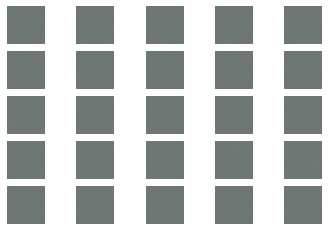

In [20]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "all_resize"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        print(X_train)

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    
        print(input_img_dir)
        print(self.class_names)
    
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



In [21]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "all_resize"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    
    #print(input_img_dir)
    #print(self.class_names)
    
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        #iterations=200000,
        iterations=5,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 33, 33, 64)      

In [22]:
#import better_exceptions
################
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

np.random.seed(0)
np.random.RandomState(0)
tf.compat.v1.set_random_seed(0)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
session = tf.compat.v1.Session(config=config)
K.set_session(session)

# root_dir = "/home/takusub/PycharmProjects/Samples/dcgan/kill_me_baby_datasets/"
#keras_dcgan.pyが保存されているディレクトリのフルパス
root_dir = "/Users/user/Desktop/m31_expt/m31_datasets/"
input_img_dir = "all_resize"
save_dir = "dcgan_v3_img/"

class DCGAN():
    def __init__(self):
        
        self.class_names = os.listdir(root_dir)
        
        self.shape = (128, 128, 3)
        self.z_dim = 100
        
        optimizer = Adam(lr=0.0002, beta_1=0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        self.generator = self.build_generator()
        # self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_generator(self):
        noise_shape = (self.z_dim,)
        model = Sequential()
        
        model.add(Dense(128 * 32 * 32, activation="relu", input_shape=noise_shape))
        model.add(Reshape((32, 32, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        model.summary()
        
        noise = Input(shape=noise_shape)
        img = model(noise)
        
        return Model(noise, img)
    
    def build_discriminator(self):
        img_shape = self.shape
        model = Sequential()
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=img_shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def build_combined(self):
        self.discriminator.trainable = False
        model = Sequential([self.generator, self.discriminator])
        
        return model
    
    def train(self, iterations, batch_size=128, save_interval=50, model_interval=10000, check_noise=None, r=5, c=5):
        
        X_train, labels = self.load_imgs()
        
        half_batch = int(batch_size / 2)
        
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        for iteration in range(iterations):
            
            # ------------------
            # Training Discriminator
            # -----------------
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            
            imgs = X_train[idx]
            
            noise = np.random.uniform(-1, 1, (half_batch, self.z_dim))
            
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # -----------------
            # Training Generator
            # -----------------
            
            noise = np.random.uniform(-1, 1, (batch_size, self.z_dim))
            
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration, d_loss[0], 100 * d_loss[1], g_loss))
            
            if iteration % save_interval == 0:
                self.save_imgs(iteration, check_noise, r, c)
                start = np.expand_dims(check_noise[0], axis=0)
                end = np.expand_dims(check_noise[1], axis=0)
                resultImage = self.visualizeInterpolation(start=start, end=end)
                # cv2.imwrite("images/latent/" + "latent_{}.png".format(iteration), resultImage)
                cv2.imwrite(save_dir + "latent_{}.png".format(iteration), resultImage)
                if iteration % model_interval == 0:
                    # self.generator.save("ganmodels/dcgan-{}-iter.h5".format(iteration))
                    self.generator.save("mb_dcgan-{}-iter.h5".format(iteration))

    def save_imgs(self, iteration, check_noise, r, c):
        noise = check_noise
        gen_imgs = self.generator.predict(noise)
        
        # 0-1 rescale
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(save_dir + '%d.png' % iteration)
        # fig.savefig('images/gen_imgs/kill_me_%d.png' % iteration)
        
        plt.close()

    def load_imgs(self):
    
        img_paths = []
        labels = []
        images = []
    # for cl_name in self.class_names:
    #     img_names = os.listdir(os.path.join(root_dir, cl_name))
    #     for img_name in img_names:
    #         img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
    #         hot_cl_name = self.get_class_one_hot(cl_name)
    #         labels.append(hot_cl_name)
    
    #print(input_img_dir)
    #print(self.class_names)
    
        for cl_name in self.class_names:
            if cl_name == input_img_dir:
                img_names = os.listdir(os.path.join(root_dir, cl_name))



                for img_name in img_names:
                    img_paths.append(os.path.abspath(os.path.join(root_dir, cl_name, img_name)))
                    hot_cl_name = self.get_class_one_hot(cl_name)
                    labels.append(hot_cl_name)
    
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)

        images = np.array(images)
        
        return (np.array(images), np.array(labels))

    def get_class_one_hot(self, class_str):
        label_encoded = self.class_names.index(class_str)
    
        label_hot = np_utils.to_categorical(label_encoded, len(self.class_names))
        label_hot = label_hot
        
        return label_hot
    
    def visualizeInterpolation(self, start, end, save=True, nbSteps=10):
        print("Generating interpolations...")
        
        steps = nbSteps
        latentStart = start
        latentEnd = end
        
        startImg = self.generator.predict(latentStart)
        endImg = self.generator.predict(latentEnd)
        
        vectors = []
        
        alphaValues = np.linspace(0, 1, steps)
        for alpha in alphaValues:
            vector = latentStart * (1 - alpha) + latentEnd * alpha
            vectors.append(vector)
        
        vectors = np.array(vectors)
        
        resultLatent = None
        resultImage = None
        
        for i, vec in enumerate(vectors):
            gen_img = np.squeeze(self.generator.predict(vec), axis=0)
            gen_img = (0.5 * gen_img + 0.5) * 255
            interpolatedImage = cv2.cvtColor(gen_img, cv2.COLOR_RGB2BGR)
            interpolatedImage = interpolatedImage.astype(np.uint8)
            resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage, interpolatedImage])
            
        return resultImage


if __name__ == '__main__':
    dcgan = DCGAN()
    r, c = 5, 5
    check_noise = np.random.uniform(-1, 1, (r * c, 100))
    dcgan.train(
        iterations=200000,
        batch_size=100,
        # save_interval=1000,
        save_interval=50, ### epoch回数が50の倍数になったときに、generator生成画像を保存
        model_interval=5000,
        check_noise=check_noise,
        r=r,
        c=c
    )


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 33, 33, 64)        0         
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 33, 33, 64)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 33, 33, 64)      

63 [D loss: 0.006963, acc.: 100.00%] [G loss: 0.045495]
64 [D loss: 0.005383, acc.: 100.00%] [G loss: 0.028441]
65 [D loss: 0.000965, acc.: 100.00%] [G loss: 0.026333]
66 [D loss: 0.002376, acc.: 100.00%] [G loss: 0.029177]
67 [D loss: 0.001216, acc.: 100.00%] [G loss: 0.042938]
68 [D loss: 0.001532, acc.: 100.00%] [G loss: 0.031579]
69 [D loss: 0.002603, acc.: 100.00%] [G loss: 0.034535]
70 [D loss: 0.000752, acc.: 100.00%] [G loss: 0.030513]
71 [D loss: 0.001431, acc.: 100.00%] [G loss: 0.037650]
72 [D loss: 0.001689, acc.: 100.00%] [G loss: 0.036312]
73 [D loss: 0.000551, acc.: 100.00%] [G loss: 0.028682]
74 [D loss: 0.001027, acc.: 100.00%] [G loss: 0.028941]
75 [D loss: 0.000515, acc.: 100.00%] [G loss: 0.034042]
76 [D loss: 0.000690, acc.: 100.00%] [G loss: 0.020065]
77 [D loss: 0.001061, acc.: 100.00%] [G loss: 0.034625]
78 [D loss: 0.001061, acc.: 100.00%] [G loss: 0.031792]
79 [D loss: 0.002510, acc.: 100.00%] [G loss: 0.042073]
80 [D loss: 0.002634, acc.: 100.00%] [G loss: 0.

206 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.004164]
207 [D loss: 0.000165, acc.: 100.00%] [G loss: 0.005603]
208 [D loss: 0.000184, acc.: 100.00%] [G loss: 0.009560]
209 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.006056]
210 [D loss: 0.000246, acc.: 100.00%] [G loss: 0.010732]
211 [D loss: 0.000176, acc.: 100.00%] [G loss: 0.009767]
212 [D loss: 0.000184, acc.: 100.00%] [G loss: 0.017199]
213 [D loss: 0.000291, acc.: 100.00%] [G loss: 0.007195]
214 [D loss: 0.000218, acc.: 100.00%] [G loss: 0.013500]
215 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.009329]
216 [D loss: 0.000265, acc.: 100.00%] [G loss: 0.008313]
217 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.009129]
218 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.005409]
219 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.005079]
220 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.006445]
221 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.004774]
222 [D loss: 0.000084, acc.: 100.00%] [G loss: 0.004473]
223 [D loss: 0.000091, acc.: 10

349 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.003792]
350 [D loss: 0.000058, acc.: 100.00%] [G loss: 0.003329]
Generating interpolations...
351 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.005327]
352 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.003197]
353 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.004578]
354 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.003794]
355 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.004444]
356 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.002203]
357 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.004413]
358 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.003153]
359 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.003172]
360 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.004434]
361 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.002874]
362 [D loss: 0.000070, acc.: 100.00%] [G loss: 0.004077]
363 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.002623]
364 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.002196]
365 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.001662]
36

492 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.001646]
493 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.001296]
494 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.001435]
495 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.001503]
496 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.001346]
497 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.001340]
498 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.002327]
499 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.002656]
500 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.002898]
Generating interpolations...
501 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.002105]
502 [D loss: 0.000109, acc.: 100.00%] [G loss: 0.002416]
503 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.002350]
504 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.002254]
505 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.001997]
506 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.002343]
507 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.002249]
508 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.002338]
50

635 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000835]
636 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.000824]
637 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.001136]
638 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.001092]
639 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.001649]
640 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.001055]
641 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.000586]
642 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.001386]
643 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.000790]
644 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.000803]
645 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.001082]
646 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.001016]
647 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.000924]
648 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000713]
649 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.001920]
650 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.001347]
Generating interpolations...
651 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.001382]
65

778 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.000775]
779 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.001246]
780 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.001157]
781 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.000986]
782 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.000625]
783 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.000920]
784 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.001976]
785 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.001909]
786 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.001447]
787 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.000519]
788 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.000562]
789 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.000606]
790 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.000569]
791 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.001183]
792 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.000593]
793 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.000506]
794 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.000679]
795 [D loss: 0.000005, acc.: 10

921 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000662]
922 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.000869]
923 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.000962]
924 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000575]
925 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.000722]
926 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000583]
927 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000361]
928 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.000639]
929 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000938]
930 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000641]
931 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000917]
932 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.000629]
933 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.000595]
934 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.000746]
935 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.001442]
936 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000442]
937 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.000691]
938 [D loss: 0.000004, acc.: 10

KeyboardInterrupt: 